# Gold Prediction ARIMA-GARCH semi model

Hello there! Thanks for passing by, I'm Franck Bui Nguyen. The "techniques" used within this paper come from the knowledge I earned throughout university, open sources and my internship at Socété Générale within the commodity department(base/precious metal). I would like to share the knowledge that I have earned to the open source community as a thanks to all the people that have contributed so far. I wish to pursue this mentality and I believe that having the ability to connect with people from around the world, collaborate and learn from each other open up a whole new way to work. I hope you will find it somewhat interesting.
If there are any typos or mistakes within the theory or other, please do reach out I would appreciate any feedback at my mail address : franck5nguyen@gmail.com

Thank you very much and enjoy !


#### Abstract: This study focuses on the gold price from Jan-2019 until Sept-2020.
Base metals:<br>
This category of metal is often use within the industrial metals in order due to their usefull characteristics within the electrical field and their cheap price.

Precious Metals<br>
Used as a way to marchandise back then, the weight of gold within a coin used to gauche the economic power of a country bacj then. It is now used for jewelery.
 
Gold<br>
One of mankind greatest dream during was to use alchemy to transmute base metal into gold. Though looking at this dream from nowadays, we can say that mankind has succesfully achieve this goal thanks to science but it is worth it? Indeed, the cost to do the process might be more expensive than the traditionnal way. However, since the digital age revolution, mankind has been in search of machine learning algorithm in order to predict the price of the golden metal, but is it possible? Perhaps someone in 100 years will look back at this post and have a good laugh?
 
Gold has always been seen as a safe heaven during time of uncertainty. It was the case during the 2008 crisis and for a more closer example: the Coronavirus. Indeed since the begining of april, financial market has been impacted by depression like never before. But it has also never seen such a bullish run. 2020 will be remembered as one of the most turbulant year in financial history and will provide a lot of data to play with.<br>

*Note*: This is not any forms of advicing strategies but rather for "passion" and academic purposes.<br>
*Note1*: Main languages used are Python, C++ and some R

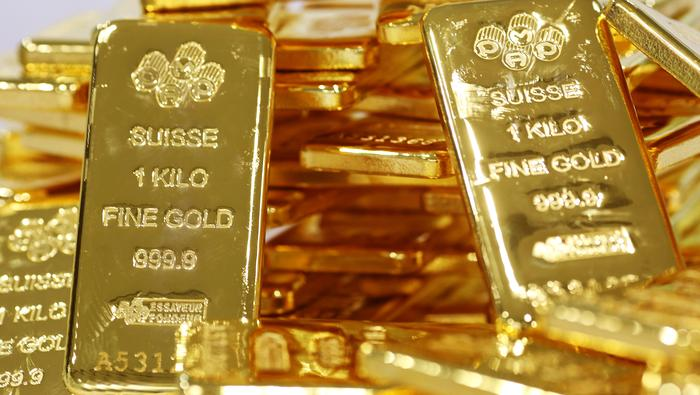

In [30]:
from IPython.display import Image
Image(filename="Image\Gold.jpg")

# Summary

* ARIMA(p,d,q) study of gold prices
* Forecast gold spot price on a short term (about 1 week in the future)
* Model calibration/ validation
* Understand the different variable that can affect the gold spot price and the interraction with all other asset classes from commodities to equities and forex
* Coronavirus impact on financial market, cross asset correlation study, focus on gold
* Volatility study and what it means on the ARIMA model
* GARCH study of gold prices

# Time Series

A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

## Additive vs Multiplicative model
### Additive model 
It is a model of data in which the effects of the individual factors are differentiated and added to model the data. Let $X_t$ be a time series value at time $t$, it can be written as : <br>
$$X_t = trend_t + seasonal_t + residual_t$$


Additive model is useful when the seasonal variation is relatively constant over time

### Multiplicative model 
trend and seasonal components are multiplied and then added to the error component. It is not linear, can be exponential or quadratic and represented by a curved line as below:
Multiplicative model is useful when the seaosnal variation increases over time
$$ X_t =trend_t*seasonal_t*error_t$$

How do we choose between those 2 models? We use multiplicative models when the magnitude of the seasonal pattern in the data depends on the magnitude of the data. On other hand, in the additive model, the magnitude of seasonality does not change in relation to time.

## How do we forecast time series?
The idea is to use past data in order to predict the future, lets take for example a weather forecast for next week. The question would be :<br> *Until when should I look in the past in order to predict the future?*.<br>

It is not reasonable to take weather data from 2010 right? Then until when should I look to make my prediction as closely as possible?<br>
Our main tool to study the gold price is time series analysis and the main models are ARMA/ARIMA and GARCH. We will have a deeper look on the hypothesis and how do we apply/code these models to fit real world data.

In [31]:
import dataMngt as dtmgt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsParam as stsp
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch as engle
from sklearn.metrics import mean_squared_error
import math
from arch import arch_model
from scipy.stats import t
import scipy.stats as stats
import warnings;
import itertools
from IPython.core.display import HTML
warnings.filterwarnings('ignore');#Disable warning


In [32]:
#get gold data from 2006 till now
all = pd.read_csv(r'C:\Coding\Python Project\Stocks\Data\stock.csv',index_col=False)

#Calculate correlation between each asset starting from corrDate
corrDate = "2020-01-01"

EQD = all.loc[(all.type == 'EQD')&(all.date>corrDate)]
EQDmarket = all.loc[(all.underlying0 == "EquityMarket")&(all.date>corrDate)]
CTY = all.loc[(all.type == 'CTY')&(all.date>corrDate)]
FX = all.loc[(all.type == 'FX')&(all.date>corrDate)]

allFormat = dtmgt.unstackData(all)
EQDFormat = dtmgt.unstackData(EQD,typeList = ['EQD'])
CTYFormat = dtmgt.unstackData(CTY,typeList = ['CTY'])
FXFormat = dtmgt.unstackData(FX,typeList = ['FX'])

First lets have a look at the data of the gold price from Jan-2005 until Sept-2020. Though we will not use all the data for our analysis but having an overall idea of the shape of what the price look like can give us an intuition on how to proceed. Second we might need data from the last 2008 financial crisis to predict our data as we are currntly going through a rough time.

  type      underlying0 underlying underlying1        date       price
0  CTY  Precious Metals       Gold         XAU  2005-01-03  428.700012
1  CTY  Precious Metals       Gold         XAU  2005-01-04  428.500000
2  CTY  Precious Metals       Gold         XAU  2005-01-05  426.600006
3  CTY  Precious Metals       Gold         XAU  2005-01-06  421.000000
4  CTY  Precious Metals       Gold         XAU  2005-01-07  418.899994


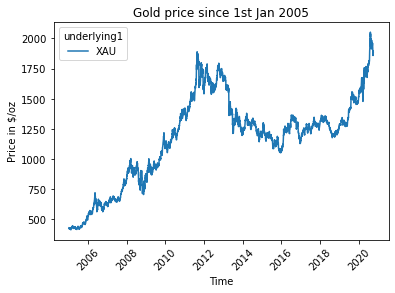

In [33]:
print(all.head())
xau = allFormat[['XAU']] #Gold price

sns.lineplot(data=xau)
plt.title("Gold price since 1st Jan 2005")
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);


# ARIMA(P,D,Q) Model

The autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series. ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

**Definition : Stationarity**

A stationary time series do not depend on the time at which the series is observed. Stationarity has 2 forms, its weak and strong form.<br>

*Weak*<br>
A time series is stationary in its weak form if its statisics do not vary and are independant from time at each instant it is observed. Statistics can be its variance or its mean throughout time.<br>
For example white noise is stationary

*Strong*<br>
A time series is stationary in its strong form if the density law of $X_t$ at a time t is the same if look at $X_{t+\epsilon}$

That is $X_t$ is stationary if $$\forall t \in [0,T], \mathcal{L}(X_t) = \mathcal{L}(X_{t+\epsilon}), \forall \epsilon > 0$$

with <br>
$\mathcal{L}(X_t)$ the density of X at time t<br>
$\epsilon$ an infinitysimal time laps with $\epsilon \rightarrow 0$

## Integrated(D)

The integration(D) represent the number of differencing operator we need to apply on the data to make it stationary. The difference operator 

The first degree with respect to $X_t$ is written as 
$$\nabla X_t = X_t - X_{t-1}$$

We deduce the $D^th$ difference as 
$$\nabla^D X_t = (1-L)^D X_t$$

With<br>
$L^k X_t = X_{t-k}$ the lag operator

Let $X_t$ be a time series with $t$ the time I am looking at and $X_t$ it's value.


Before jumping heads on the hard stuff, we need to figure out which out of the additive and the multiplicative model is the most accurate. Lets first have a look at the price since 2019-01-01 until now.

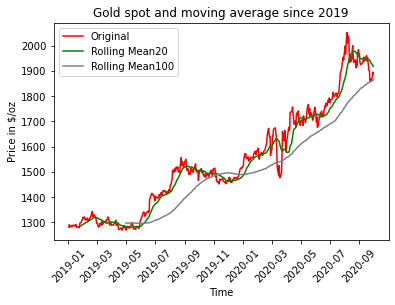

In [34]:
xau = xau[xau.index>="2019-01-01"].dropna() # Filter for 2020 only
rolling_mean20 = xau.XAU.rolling(20).mean()
rolling_mean100 = xau.XAU.rolling(100).mean()

plt.plot(xau, color = 'red', label = 'Original')
plt.plot(rolling_mean20, color = 'green', label = 'Rolling Mean20')
plt.plot(rolling_mean100, color = 'grey', label = 'Rolling Mean100')

plt.legend(loc = 'best')
plt.title('Gold spot and moving average since 2019')
plt.xlabel('Time')
plt.ylabel('Price in $/oz')
plt.xticks(rotation=45);

The above plot represents an overall shape of the gold price since 2019 (closed price. <br>
Without using any mathematics, we can clearly see a tendency throughout time, that is overall the price has been increasing over the months. Moreover if we look closely, both moving average 20 and 100 days keep increasing as time passes by.

We can first sniff out that this time series might not be a stationary one, if we look at an interval between 2 months in 2019, we can clearly see that the average 1 year later is not the same. Lets prove it mathematically with a statistics test using the augmented Dickey Fuller test

H0 : The time series is not stationary

H1 : The time series is stationary



In [35]:
stsp.stationary_test(xau)

Results of Dickey-Fuller Test:
Test Statistic                  -0.219530
p-value                          0.936153
No. Lags Used                   10.000000
Number of Observations Used    510.000000
Critical value (1%)             -3.443237
Critical value (5%)             -2.867224
Critical value (10%)            -2.569797
dtype: float64


From the above result, we have a significant p-value which means that the probability to reject incorrectly H0 is high. We deduce that the time series is **not stationary**. This is what we have already proved just by looking at it but I now prove it mathematicaly.<br>
Data needs to be processed to remove the tendency and seasonality and to do this we will apply various transform such as the differenciation.

$$\nabla X_t = X_t - X_{t-1}$$

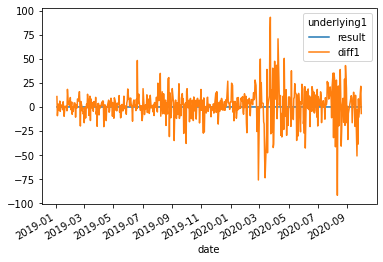

In [36]:
xauTransform = xau.copy()
xauTransform['result'] = xauTransform['XAU'].pct_change()
xauTransform['diff1'] = xauTransform['XAU'].diff(periods=1)

#xauTransform['lnRatio'] = np.log(xauTransform['XAU'] / xauTransform['XAU'].shift(1))
xauTransform = xauTransform.dropna()
#xauTransform['logResult'] = np.log(xauTransform.result)
xauTransform.drop(columns='XAU',inplace=True)
xauTransform.plot();




In [37]:
stsp.stationary_test(xauTransform.diff1)

Results of Dickey-Fuller Test:
Test Statistic                -8.019205e+00
p-value                        2.098433e-12
No. Lags Used                  9.000000e+00
Number of Observations Used    5.100000e+02
Critical value (1%)           -3.443237e+00
Critical value (5%)           -2.867224e+00
Critical value (10%)          -2.569797e+00
dtype: float64


From the above, ADF gives us
$$ TValue < C_1 < C_5 < C_{10} < PValue$$
The probability to reject $H_0$ incorrectly is fairly small and thus $X_1$ that is the data is stationary.

We deduce that **D = 1**

## Auto-Regressive(P)

Def : Let $X_t$ be a processus. $X_t$ is autoregressive if the present value is weighted average of its past values. In other term, 
$$ X_t = \sum^p_{i=1}\alpha_i X_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{L}(0,\sigma^2), \sigma< \infty$<br>
$\theta_i$ parameter of the model<br>
p: The number of lag obsevations included in the model, also called the lag order

ACF strong for lag k the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.<br>
PACF We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

## Moving Average(Q)

Def : Let $X_t$ be a processus, $X_t$ is a moving average process if the present value of series is defined as a linear combination of past errors. The processys corrects itself depending on the previous error until the q-eme.

$X_t$ can also be writen as:
$$ X_t = \sum^q_{i=1}\theta_i \epsilon_{t-i} + \epsilon_t$$
with:<br>
$\epsilon_t$ white noise $\mathcal{L}(0,\sigma^2), \sigma < \infty$<br>
$\alpha_i$ parameter of the model<br>
q: the size of the moving average window, also called the order of moving average



ACF strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation.

PACF  we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

## ARMA(P,Q) Model
Given a time series of data $X_t$ , the ARMA model is a tool for understanding the future values of $X_t$. The AR part involves regressing the variable on its past values. The MA part involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past.

$$X_t - \alpha_{1} X_{t-1}-...- \alpha_p X_{t-p} = \epsilon_{t} + \theta_1 \epsilon_{t-1} + .... + \theta_q \epsilon_{t-q}$$
$$ X_t = \underbrace{\sum^p_{i=1}\alpha_i X_{t-i}}_{AR(P)} + \underbrace{\sum^q_{i=1}\theta_i \epsilon_{t-i}}_{MA(Q)}$$


## Autocorrelation function

Def: The autocorrelation is the correlation of a signal with a delayed copy of itself as a function of delay. It is mainly used for finding repeating patterns,such as the presence of a periodic signal obscured by noise.

We find optimum features or order of the MA(Q) process using the ACF plot, as being an MA process it doesn’t have seasonal and trend components so we get only the residual relationship with the lags of time series in the ACF plot.

## Partial-Autocorrelation function

Def: The partial auto-correlation  finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag.

We find optimum features or order of the AR(P) process using the PACF plot, as it removes variations explained by earlier lags so we get only the relevant features.


Lets find out the parameters of our model by looking at the ACF and the PACF.

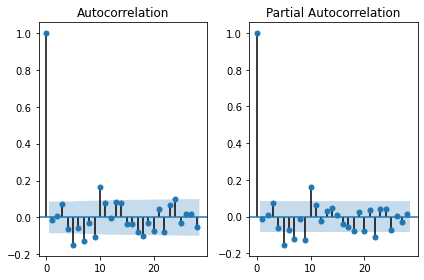

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_acf(xauTransform.diff1,ax=ax[0])

plot_pacf(xauTransform.diff1,ax=ax[1])

plt.tight_layout()
plt.show()

From the above we can see a first spike at 0 lag for both plots. It is normal as it represents the correlation with itself and it will always be 1.

We see a drop after lag 3, we deduce:<br>
AR(p) = 3 <br>
MA(q) = 3 <br>

We will then choose the ARIMA(3,1,3) to predict our gold price.

## Train test data split

The train-test split is a technique for evaluating the performance of a machine learning algorithm.
It can be used for classification or regression problems and can be used for any supervised learning algorithm.The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

-Train Dataset: Used to fit the machine learning model.<br>
-Test Dataset: Used to evaluate the fit machine learning model.

The objective is to estimate the performance of the machine learning model on new data: data not used to train the model. This is how we expect to use the model in practice. Namely, to fit it on available data with known inputs and outputs, then make predictions on new examples in the future where we do not have the expected output or target values. The pivot date will be the date that split the data in half.

In [39]:
pivotDate = "2020-08-23" #Split data before Jan-2020 and after
train = xau[xau.index < pivotDate].copy() #Train sample from 2019-01-01 until pivotDate
test = xau[xau.index >= pivotDate].copy() #test sample from pivotDate onward

# Prediction

Before fitting our model, we must address an issue that is often occurs within machine learning and especially at this stage that is Overfitting/Underfitting.

## Overfitting and Underfitting

### Overfitting
Overfitting refers to a model that models the training data too well.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. To be more specific, during the process of predicting the price if we have too many features, the learned model may fit the traning data to well but fails to generalize to another new traning sets. It is also known as the Bias and Variance trade off.

### Underfitting
Underfitting refers to a model that can neither model the training data nor generalize to new data.

An underfit machine learning model is not a suitable model and will be obvious as it will have poor performance on the training data.

The goal to validate a good model is to find the sweet spot between Overfitting and Underfitting, however usually the main issue comes from Overfitting and there are several way to deal with this.

OUT SAMPLING AND IN SAMPLING
Back testing

## Model fitting
Model fitting is a measure of how well a machine learning model generalizes to similar data to that on which it was trained. A model that is well-fitted produces more accurate outcomes. A model that is overfitted matches the data too closely. A model that is underfitted doesn’t match closely enough. 

We now fit our model ARIMA(3,1,3) on our training sample and will back test on the rest of the data. 

## Possible way to overcome overfitting
First, one main issue of overfitting is that during the process of finding a model to replicate a certain random variables, we may have added to many variables. By first manually select which meaningful features to keep is the first step to have a better prediction.<br>
Second there exist model selection algorithm that we will see after

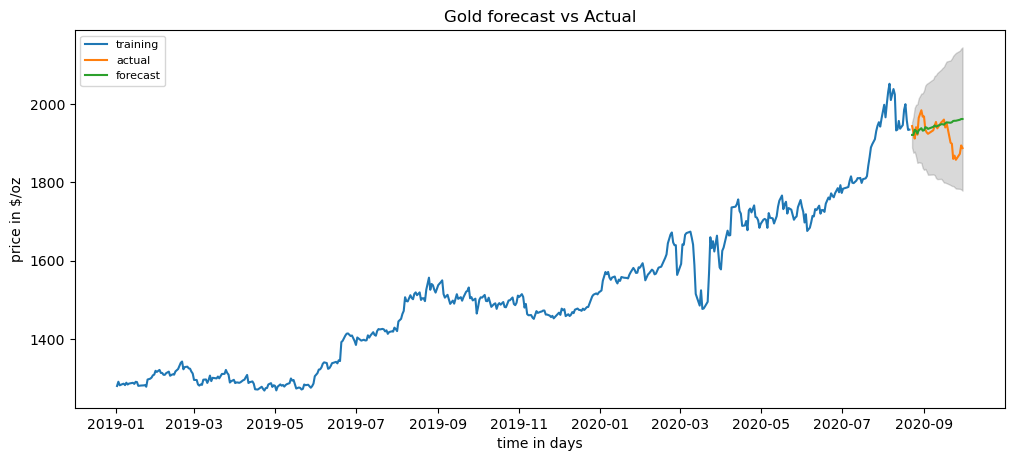

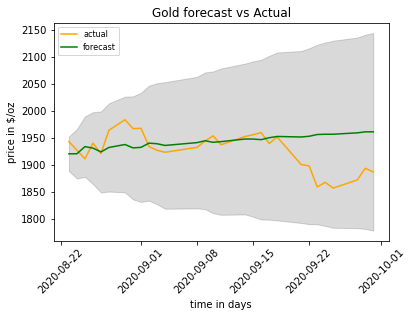

In [40]:
modelArima = ARIMA(train, order=(3,1,3))#FREQ Parameter needs to be checked !!!
fitArima = modelArima.fit();
sizePredict = len(test)
fcArima, seArima, confArima = fitArima.forecast(steps=sizePredict, alpha=0.05)
fc_seriesArima = pd.Series(fcArima, index=test.index)
lower_series = pd.Series(confArima[:, 0], index=test.index)
upper_series = pd.Series(confArima[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_seriesArima, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)

plt.title('Gold forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('time in days')
plt.ylabel('price in $/oz')
plt.show()

plt.plot(test, label='actual',color="orange")
plt.plot(fc_seriesArima, label='forecast',color="green")
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)

plt.title('Gold forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('time in days')
plt.ylabel('price in $/oz')
plt.xticks(rotation=45);


Lets focus on the back testing sample and plot a graphic to understand where do we stand regarding the forecasting model.

# Calibration

The goal in this part is to callibrate our model, that is find the optimal parameter (p,d,q) 

Though the tendancy of the forecast seem to match, the model could not predict the deep that happened around mid September.<br>
Is there a way to have a better approximation for a 1 week forecast?


In [41]:
#WARNING CALIBRATION PART MIGHT TAKE A LONG TIME. NEED TO RUN ONLY ONCE
p=d=q =range(0,6)
pdq=list(itertools.product(p,d,q))
calibArimaResult = []

for param in pdq:
    try:
        modelArimai = ARIMA(train,order=param)
        fitArimai = modelArimai.fit()
        calibArimaResult.append(fitArimai.aic)
    except:
        continue
print("Optimal ARIMA model, Parameter:(4,1,5)","AIC:",min(calibArimaResult))#TODO Optimize min calculation

Optimal ARIMA model, Parameter:(4,1,5) AIC: 4130.778342211464


After looping through all the possible parameters, the optimal model given by the AIC is ARIMA(4,1,5) with an AIC of aobut 4130. Lets plot this model to compare with the one that we choose from the ACF and PACF plot.

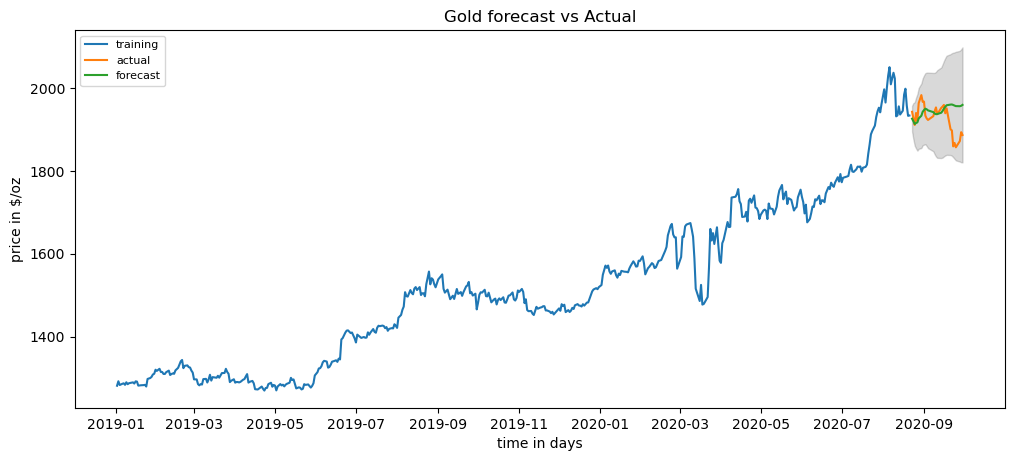

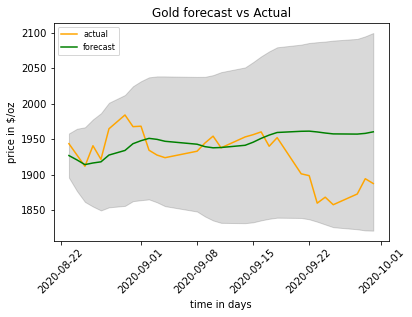

In [42]:
modelArima = ARIMA(train, order=(4,1,5))#FREQ Parameter needs to be checked !!!
fitArima = modelArima.fit();
sizePredict = len(test)
fcArima, seArima, confArima = fitArima.forecast(steps=sizePredict, alpha=0.05)
fc_seriesArima = pd.Series(fcArima, index=test.index)
lower_series = pd.Series(confArima[:, 0], index=test.index)
upper_series = pd.Series(confArima[:, 1], index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_seriesArima, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)

plt.title('Gold forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('time in days')
plt.ylabel('price in $/oz')
plt.show()

plt.plot(test, label='actual',color="orange")
plt.plot(fc_seriesArima, label='forecast',color="green")
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)

plt.title('Gold forecast vs Actual')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('time in days')
plt.ylabel('price in $/oz')
plt.xticks(rotation=45);

After looping several through several model, we conclude that the ARIMA(4, 1, 5) is a good fit.
To be more specific we can write the prediction at time $t$ as below with an integration order of 1: 

$$ X_t =  \sum_{i=1}^4 \alpha_i X_{t-i} + \sum_{i=1}^5 \theta_i \epsilon_{t-i}$$ 


# Model validation

The goal of this part is to validate the model by comparing the selected model with other different one. We will assess it through statistical tests.

## Root Mean Squared Error(RMSE)

The RMSE is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power.<br>
Let $ \hat{\theta} $ be the estimator of $\theta$,

$$RMSE(\hat{\theta})=\sqrt{\frac{\sum^n_{i=1}(\hat{y}_i-y_i)^2}{n}}$$

with:<br>
y=actual target<br>
$\hat{y}$=predicted target<br>

Lets calculate the RMSE between the test sample and the forecast sample

In [43]:
print("RMSE Test set ARIMA(3,1,3) : ",np.sqrt(mean_squared_error(test,fcArima)))

RMSE Test set ARIMA(3,1,3) :  45.57467200584844


In our cases, the RMSE for the ARIMA(3,1,3) model for our test sample is about : 44.76

# Conclusion

Our main goal is to predict the gold price within a near future. We have applied several test to understand the behavior of the data. In the end we've come to an ARIMA(4,1,5) model where we fitted the model on a train sample(until a pivot date) and tested on the rest of the sample. Overall the tendancy for the first prediction seems to be on the same track, the model was not able to predict the sell-off that happened around the 20th of september-2020.<br>
There are couple of things to do before moving in. We need to first, calibrate our model and find out the optimal parameter (p,d,q), cross validate it and try out-sampling and in-sampling.

It is no where near the objective that we are looking for, but what are we missing then? There are a couple of things that need to be addressed.<br>
- The independance and law of the residuals<br>
- The volatility of the underlying, more specifically the residuals
- Coronavirus impact on the market

The main draw back of an ARIMA model is that it does not capture the volatility of a stock price. Within the financial market, a simple ARIMA model is not enough to predict accurately. The main issue is : sell-off. Indeed the ARIMA model capture "only" the first moment of a random process but does not capture the conditional volatility that is often seen in finance. The main driver is that usually a small movement in the asset implies a greater variance.<br>
For example when the gold drops below a certain threshold, stop-losses will be triggered creating an even more significant drop. The ARIMA model does not capture conditional variance. 

# Coronavirus 
The coronavirus hitted financial market around early April 2020 as we can clearly see the deep. During the following month, gold has seen an un-precedented bullish market. The first reason is that during time of uncertainty, investissors wish to hedge themselves against various factors, for example the power of a money can severely decrease if a country is heated severely by the crisis or hedging against potential volatil underlying asset. One way to do so is to invest in safe heavens and for ages, gold has proven to be safe and especially in emerging countries. It is a well known fact that underlying usually do not have any correlation between each other except some of them. However during a crisis, assets start to correlate between each other.

The goal of this section is to find the impact of the coronavirus on the financial market in order to find any pattern or relevant information that we can use.

Lets have a look at the equity market and precious metal market throughout 2020

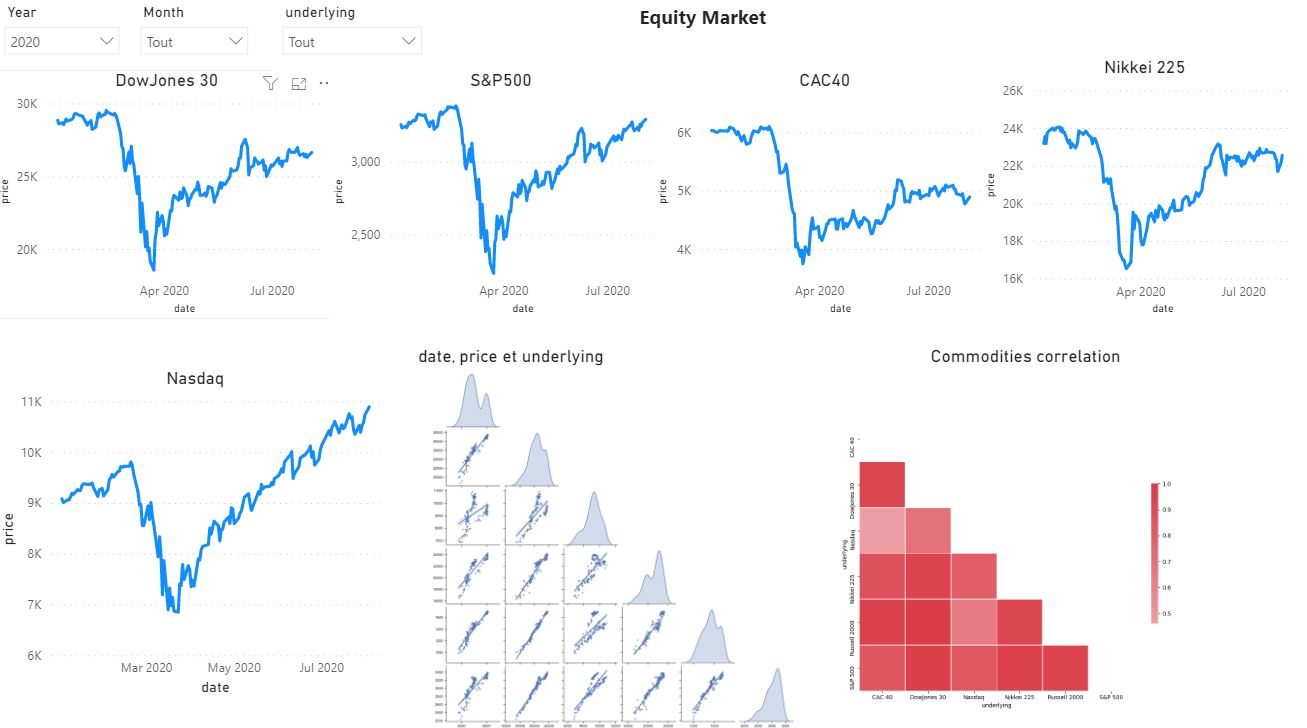

In [44]:
Image(filename="Image\Equities Market.jpg")

With a first look at the equity market, during the coronavirus period all equity index were correlated
We identify a strong linear correlation during this time ... . The idea behind this study is to find pattern behind several index that might be correlated but with a time lag. For example, there might be 2 index that are corellated between each other, positive correlation between 2 index means that when the price of one stock implies the rise in the other. This study will be very usefull if we can find 2 index A and B that are correlated but with a time lag, that if A moves up implies B will move up but with a delay.



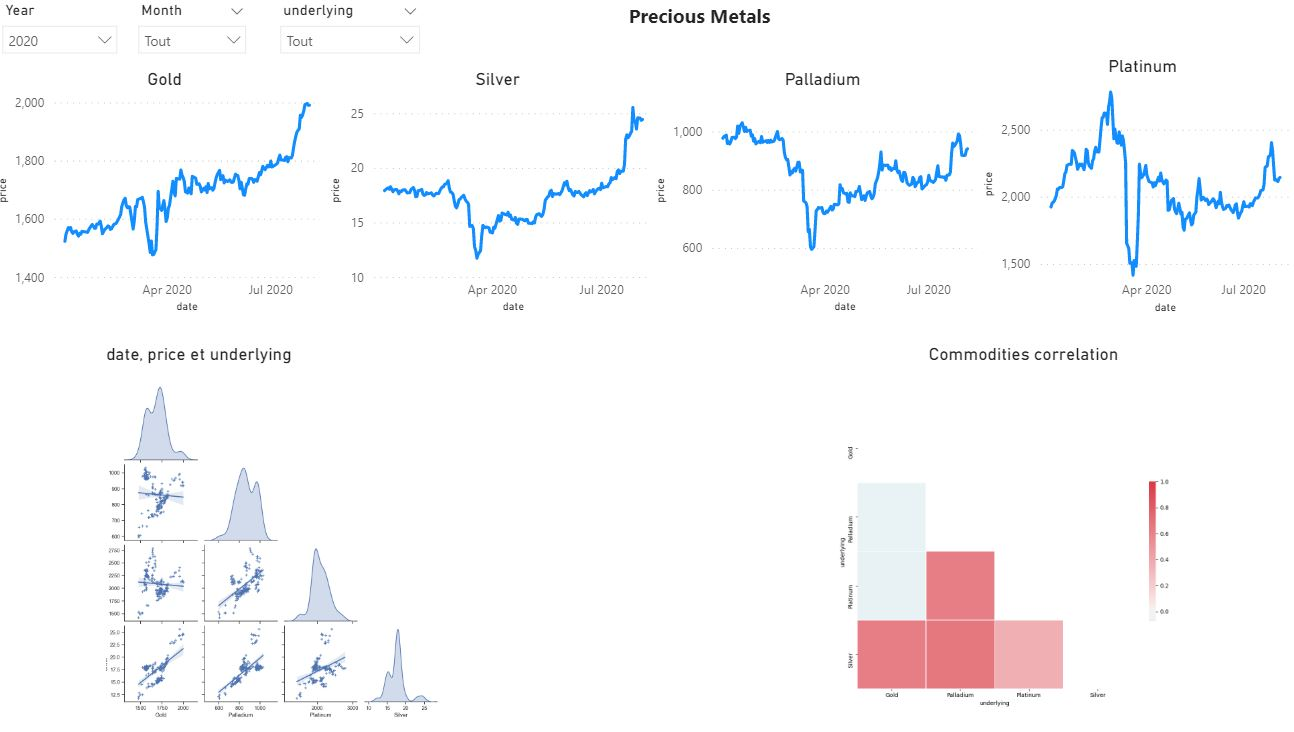

In [45]:
Image(filename="Image\Precious Metals.jpg")

[]

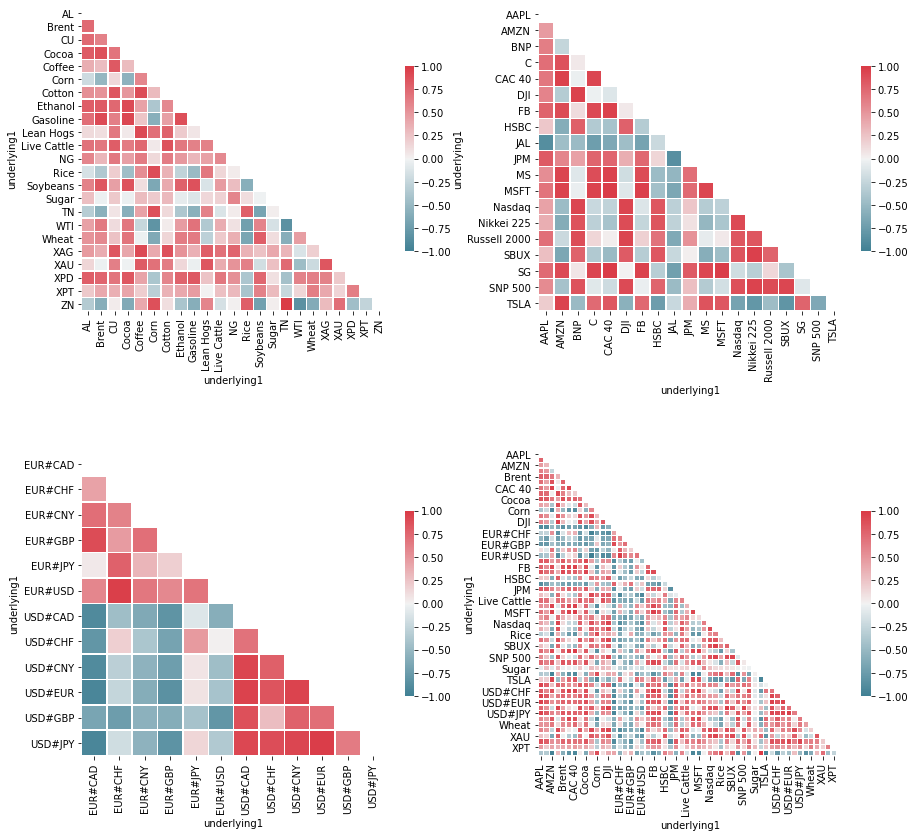

In [46]:
#Plot Covariance matrix as a heatmap

allFormat2 = allFormat.loc[allFormat.index>corrDate]

corrAll, maskALL = stsp.corrParam(allFormat2)
corrEQD, maskEQD = stsp.corrParam(EQDFormat)
corrCTY, maskCTY = stsp.corrParam(CTYFormat)
corrFX, maskFX = stsp.corrParam(FXFormat)

fig,((ax1,ax2),(ax3,ax4)) =  plt.subplots(2,2,figsize=(15,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrCTY, mask=maskCTY,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
sns.heatmap(corrEQD, mask=maskEQD,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
sns.heatmap(corrFX, mask=maskFX,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
sns.heatmap(corrAll, mask=maskALL,cmap=cmap,vmax = 1, center=0, vmin =-1, square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)

fig.tight_layout(pad=70.0)

plt.plot()

## Volatility issue due to Coronavirus
A change in the variance over time can cause problems when modeling time series. There are some time series where the variance changes consistently over time. This property of the series is called heteroskedasticity. We talked about the issue that the ARIMA model cannot handle : non constant volatility throughout time<br>
Indeed, the short caused by lockdown is a good example that demonstrate the variaty of financial data. Spliting the time series into its different component, the residual is the only parameter that has a randoim component. We thus need to study the law of the residuals in order to have a better prediction which is the purpose of the chapter.


## Heteroscedasticity 

A processus $(x_1, x_2, x_3, ..., x_n)$ is heteroscedastic if the variability of the residual is different throughout its element. In finance, it usually measure the variance or the volatility of a specific underlying, in our case it is the gold.<br>

Let $y_i = \alpha x_i + \epsilon_i, \forall i \in [1:N]$ be a random processus which can be splitted into a determinist part being $\alpha$ the matrix of coefficient, X and its random part being $\epsilon$ the residuals.<br>
The data are homoskedastic if $\mathcal{V}(\epsilon_i)=\sigma^2$ with $\sigma$ constant, if not the processus is heteroskedastic.<br>

More generaly<br>
$\begin{pmatrix}y_1\\y_2\\.\\.\\y_n \end{pmatrix} = 
\alpha X + \epsilon  = 
\begin{pmatrix}\alpha_1 &0&0&0&0\\0&\alpha_2&0&0&0\\.&.&.&.&.\\.&.&.&.&.\\0&0&0&0& \alpha_n \end{pmatrix}
\begin{pmatrix}x_1\\x_2\\.\\.\\x_n \end{pmatrix} + 
\begin{pmatrix}\epsilon_1\\ \epsilon_2\\.\\.\\ \epsilon_n \end{pmatrix}$

with,
$\mathcal{L}(\epsilon_i)=\mathcal{L}(\mu,\sigma^2(\omega))$<br>

Lets decompose the stationarised data to have a proper look on the residuals.

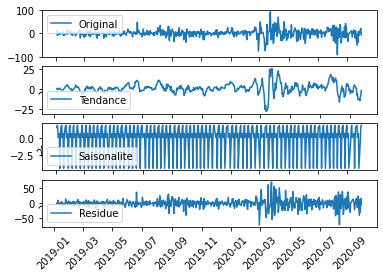

In [47]:
xauDecomposition = seasonal_decompose(xauTransform.diff1, period=7)
xauTrend = xauDecomposition.trend
xauSeasonal = xauDecomposition.seasonal
xauResidual = xauDecomposition.resid

#xauDecomposition.plot()
plt.subplot(411)
plt.plot(xauTransform.diff1,label="Original")
plt.xticks(rotation=45);
plt.legend(loc='best')
plt.subplot(412)

plt.plot(xauTrend,label="Tendance")
plt.xticks(rotation=45);
plt.legend(loc='best')
plt.subplot(413)

plt.plot(xauSeasonal,label="Saisonalite")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.subplot(414)

plt.plot(xauResidual,label="Residue")
plt.xticks(rotation=45)
plt.legend(loc='best');

The first graphic shows $\bar{X_t}=X_t-X_{t-1}$, and the following is its decomposition into several component. The one that we are interested in is the last on : the residuals

There are two main noticable behavior that is before the coronavirus and after. During the first bit, the residuals "seems" to , however as we hit arround March values start to move abit more. it is a first indicator that our residuals might not be heteroscedastic. This is a major deal breaker for the ARIMA model. Lets have a closer look at this notion.

# Variance

Variance measures how far a set of numbers is spread out from their average value.
$$ \sigma^2 = \frac{\sum^N_{i=1}(x_i-\bar{x})^2}{N-1}$$
<br>
with:<br>
N sample size <br>
N-1 degree of freedom<br>
$\bar x$ mean of the data

Volatility is a statistical measure of the dispersion of returns for a given security or market index. In most cases, the higher the volatility, the riskier the security. Volatility is often measured as either the standard deviation or variance between returns from that same security or market index.

## Historical volatility
Historical volatility gauges the fluctuations of underlying securities by measuring price changes over predetermined periods of time. It is the less prevalent metric compared to implied volatility because it isn't forward-looking.


### Annual volatility

$$Volatility_{Annual}=\sqrt{252}*Volatility_{daily}$$

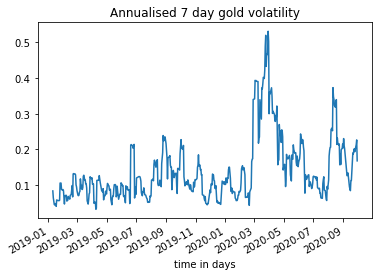

In [48]:
xauTransform['vol'] = xau.XAU.pct_change().rolling(7).std()*(252**0.5) #TO CHANGE FOR XAUTRANSFORM, ADD INTO XAU
xauTransform['vol'].plot()
plt.title('Annualised 7 day gold volatility')
plt.xlabel('time in days');

The above plot describes the annualised volatility, the most significant variation is arround 2020-03. The main cause is the significant drop of about 25% that happened when first lockdown was imposed worldwide. Thus, variance is not constant throughout time and it is a deal breaker for the ARIMA model. We need to modelise the volatility or the variance of the residuals as a random variable throughout time. 

## Are the residuals independent and identically distributed?

One hypothesis of the residuals is that they need to be independent and identically distributed. Lets have a look mathematically.

### Ljung-box test
The Ljung-box test is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero between the current value and the value with a certain lag.

H0 : The data are independently distributed (Corr = 0)<br>
H1 :  The data are not independently distributed; they exhibit serial correlation (corr !=0)

Lets have a look at the gold residuals square until lag 6 with the above test.

In [49]:
ljung = acorr_ljungbox(xauResidual.dropna(),return_df=True,lags=7)#TODO check if 0 is in or not
print("Ljung Box test sur les résidus carrés")
for i in range(len(ljung)):
    print("lag :",i,"stat value:",round(ljung.iloc[i].lb_stat,2),"p-value:",round(ljung.iloc[i].lb_pvalue,2))



Ljung Box test sur les résidus carrés
lag : 0 stat value: 30.51 p-value: 0.0
lag : 1 stat value: 48.07 p-value: 0.0
lag : 2 stat value: 55.67 p-value: 0.0
lag : 3 stat value: 58.92 p-value: 0.0
lag : 4 stat value: 60.99 p-value: 0.0
lag : 5 stat value: 63.37 p-value: 0.0
lag : 6 stat value: 68.09 p-value: 0.0


The above code used the Ljung-Box test to test wheither the correlation between the time series at the $t$ and until $t-6$ is 0 or not. From the above, we have all p-value fairly small. The probability to reject H0 incorrectly is almost none thus accept the H0 hypothesis which states that residuals squarred until lag 6 are IID.

## Distribution law of residual

We have proved in the last chapter that the residuals are IID. But what is the law that these residuals follow?<br>
The goal is to find the density law of the residuals. There are several test that can be apply to answer this question, lets have a proper look.

### Gaussian distribution and test

The gaussian density $\mathcal{N}(\mu,\sigma^2)$ is given by 

$$ f(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp^{-\frac{1}{2 \sigma^2}(x-\mu)^2}$$

with:<br>
$\mu$ mean of the data<br>
$\sigma$ standard deviation of the data<br>

To test whether our data follows a gaussian density or not, we will use the Jarque–Bera test. It is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution.

### Student distritution and test

As a remember, T follows a student density with k degree of freedom if it can be written as : 
$$ T = \frac{Z}{\sqrt{U/k}} $$

with <br>
Z ~ $\mathcal{N}(0,1)$<br>
U ~ $\chi^2$<br>
k the degree of freedom

Lets have a look at the normalised residuals with respect to some main densities.

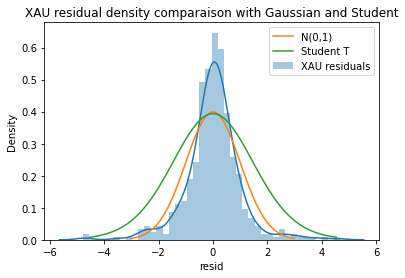

In [50]:
sns.distplot(stsp.standardized(xauResidual),label="XAU residuals");
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma),label='N(0,1)')

rv = t(df=20, loc=0, scale=1)
xt = np.linspace(rv.ppf(0.0001), rv.ppf(0.9999), 100)
yt = rv.pdf(x) 

plt.plot(xt,yt,label='Student T')
plt.legend(loc='best')
plt.title("XAU residual density comparaison with Gaussian and Student")
plt.show()


With a first look, we can see that the residuals do not follow the standard gaussian nor the student(.,.). Indeed values are much more compact arround the mean with a smaller variance than other distribution. The tail of the residuals seems flatter than the others. Lets now approximate the density distribution.

# GARCH
To model a change in variance in a time series that is time dependent we have different ways. We will look at the GARCH model in this chapter.

## GARCH Model
The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods error terms, often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model, if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.

ARCH models are a popular class of volatility models that use observed values of returns or residuals as volatility
shocks. GARCH(p,q) model is specified as:

$$ r_t = \mu + \epsilon_t $$

$$ \epsilon_t = \epsilon_t \sqrt{\omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i} + \sum_{i=1}^q \beta_i \sigma_{t-i}^2} =\epsilon_t \sigma_t $$
$$ \epsilon_t^2 = \epsilon_t^2 * (\omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i} + \sum_{i=1}^q \beta_i \sigma_{t-i}^2) =\epsilon_t^2 \sigma_t^2 $$
$$ \sigma^2_t =  \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i} + \sum_{i=1}^q \beta_i \sigma_{t-i}^2$$

with:<br>
$r_t$ the daily return of a data<br>
$\epsilon_t$ ~ $N(0,1)$, the white noise<br>
$\sigma_t$ the standard deviation
 

In other word, this model forecasts the future price depending on its past value up to a certain point and takes into account past volatility up to a certain point. The last part is the signature part of an garch model, it represents the conditional volatility. As seen in the chapter above, gold volatility is sometimes "bursty" for example during the coronavirus period. Sometimes the gold price range is more constant. Indeed, if todays volatility is highn there is a higher chance that tomorrow's volaility will be high.
We will now forecast the gold return by taking into account that the volatility is also a random variable.

Lets have a look again at what the gold return in pourcentage throughout the last year.

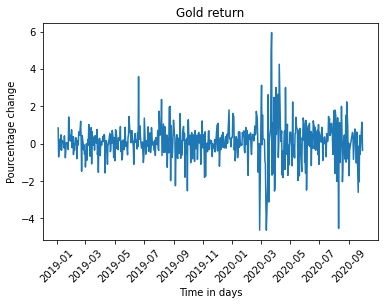

In [51]:
returns = xau.pct_change().dropna()*100
returns2 = returns**2
plt.plot(returns)
plt.title("Gold return")
plt.xlabel("Time in days")
plt.ylabel("Pourcentage change")

plt.xticks(rotation=45);

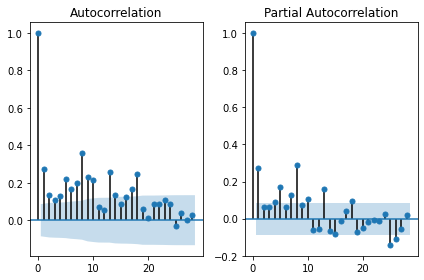

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2)

plot_acf(returns2,ax=ax[0])

plot_pacf(returns2,ax=ax[1])

plt.tight_layout()
plt.show()

There is a significant variance decrease after the 1st difference for both pacf and acf. We will go first with the GARCH(1,1) model to have an insight. We will calibrate the model after we have figured out how this model look in order to adjust.<br>
p=1<br>
q=1<br>

In [53]:
garchModel = arch_model(returns, p=1, q=1)
garchFit = garchModel.fit()
garchFit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2563.2195848574074
Iteration:      2,   Func. Count:     17,   Neg. LLF: 178768594591.05182
Iteration:      3,   Func. Count:     25,   Neg. LLF: 926.2337419958429
Iteration:      4,   Func. Count:     32,   Neg. LLF: 829.9825009198618
Iteration:      5,   Func. Count:     38,   Neg. LLF: 681.17457741885
Iteration:      6,   Func. Count:     44,   Neg. LLF: 676.8432755691558
Iteration:      7,   Func. Count:     49,   Neg. LLF: 676.8430547161914
Iteration:      8,   Func. Count:     54,   Neg. LLF: 676.8430365114727
Iteration:      9,   Func. Count:     59,   Neg. LLF: 676.8430351818927
Iteration:     10,   Func. Count:     63,   Neg. LLF: 676.8430351818819
Optimization terminated successfully    (Exit mode 0)
            Current function value: 676.8430351818927
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    XAU   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -676.843
Distribution:                  Normal   AIC:                           1361.69
Method:            Maximum Likelihood   BIC:                           1378.70
                                        No. Observations:                  520
Date:                Mon, Dec 06 2021   Df Residuals:                      519
Time:                        21:53:58   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0611  3.494e-02      1.748  8.045e-02 [-7.405e-03,  0.130]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0336  1.595e-02      2.104  3.536e-02 [2.301e-03,6.483e-02]
alpha[1]       0.0918  3.413e-02      2.691  7.133e-03   [2.494e-02,  0.159]
beta[1]        0.8747  3.639e-02     24.040 1.060e-127     [  0.803,  0.946]
============================================================================

Covariance estimator: robust
"""

Lets fit our GARCH(1,1) model and plot the returns and the volatility in the same plot.

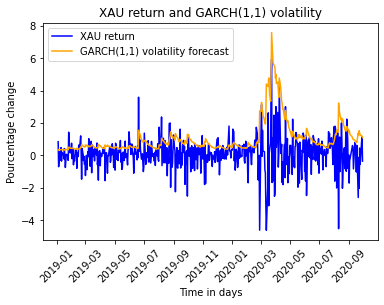

In [54]:
predGarch = garchFit.forecast(horizon=1,start = "2005-01-04")
predVar = predGarch.variance
plt.plot(returns, color="blue", label="XAU return")
plt.plot(predVar,color="orange", label="GARCH(1,1) volatility forecast")
plt.title('XAU return and GARCH(1,1) volatility')
plt.xlabel("Time in days")
plt.ylabel("Pourcentage change")
plt.xticks(rotation=45);
plt.legend(loc= "best")
plt.show()


The above graphic gives us a very interesting data visualisation by helping us to understand how volatility reacts to price shock. Though we do not have that much understanding yet of this famous non constant variance, it is just a matter of time before we will figure it out.

-The blue plot is the actual, *realised*, daily pourcentage shock on gold closed price from Jan-1st, 2019 until Sept-29, 2020.

-The yellow plot is the 1 day, GARCH(1,1) volatility forecast for the same period.

What we are expecting is that when prices are more volatile, variance should increase as well. Fortunately, it is exactly what we are looking at. Volatility forecast matches the pick, indeed fore example during the coronavirus crisis, the model also follows the same pattern of the return.

#### What needs to be done

Although it seems that our volatility model is quite accurate, should we not ask ourselves if this forecast is genuine or not? or perhaps is there a better way to approximate?<br>

-Lets get this out of the way first, though volatility forecasting seems alright, the main issue is that fore each day, say $t$, then $\forall t$ from 1st-Jan 2019 until 29th-Sept 2020, we do not actualise the model.<br>
The accurate way is to do a rolling forecast meaning. Each of the $t$'s day we forecast the $t+1$'s volatility. Then the $t+1$'s realised volatility is available, we should compare the forecast valatility(calculate on the $t$'s day) and compared to the truly realised volatility(the $t+1$'s realised) and incorpore the $t+1$'s volatility within our model and forecast the day after.

-Calibration and model validation still need to be done to find the optimal (p,q) pair for the GARCH model and find the optimal residuals density distribution.

# Biographie

* Wikipedia
* https://www.researchgate.net/publication/324273329_Trading_gold_future_with_ARIMA-GARCH_model <br>
* https://otexts.com/fpp2/
* https://medium.com/@anusha.gajinkar/time-series-regression-using-heteroscedasticity-models-88cd2dc4a32